In [1]:
%load_ext autoreload
%autoreload 2

import os
import re
import pickle

# Get project's root directory
BASE_PATH = re.search(r'.+(Team5)', os.getcwd())[0]
os.chdir(BASE_PATH)
BASE_PATH

DATA_DIRECTORY = './data'

## Task 1

In [7]:
"""
# TASK 1: Compute image descriptors (QS1)

Color Histogram:
    - gray level / concatenate color component histograms
    - color space RGB, CieLab, YCbCr, HSV.
    - Compulsory to use 1D histograms!
"""

from src.image_dataset import ImageDataset, ColorSpace
from src.image import ColorSpace, Image

In [6]:
# Load the DataBase and the Query 1
#BDDataset = ImageDataset(f'{DATA_DIRECTORY}/BBDD', colorspace=ColorSpace.HSV, interval=1)
QueryDataset = ImageDataset(f'{DATA_DIRECTORY}/qsd1_w1', colorspace=ColorSpace.HSV, interval=1)
QueryDataset.change_colorspace(new_colorspace=ColorSpace.CieLab)

In [ ]:
# Plot descriptor (histogram of each color channel) for the first image of the Query dataset. Colorspace: HSV & bin interval size=1
QueryDataset.images[0].plot_histograms()
QueryDataset.images[0].show_original()
QueryDataset.images[0].show()

## Task 2

In [5]:
"""
# TASK 2: Similarity measures

Distance:
    - Euclidean distance
    - L1 distance
    - χ2

Similarity:
    - Histogram intersection (similarity)
    - Hellinger kernel (similarity)
"""

# Implementation of the distances, similarities and evaluation metrics
from src.metrics import *

## Task 3

In [ ]:
""" 
Before submiting the results for testing with QST1, let's find the methods that work better.
We will try to optimize mAP@K with the parameters: 
   - Colorspace of the image 
   - bin_size of the hitograms 
   - Metric to compute differences between descriptors (distance or similarity).
   - Handling of the three distances (one for each channel) before computing mAP@K: Mean, min, max, sum...
"""

In [8]:
from typing import Dict, List
import numpy as np
from src.metrics import DistanceType, SimilarityType, apk

def compute_results_by_distance(
      bdd_dataset: ImageDataset,
      query_dataset: ImageDataset,
      ground_truth: List[List[int]],
      distance_type: DistanceType = DistanceType.l1
   ) -> Dict:

   result = []
   distances_result = []
   for image in query_dataset:
      distances_list = []
      for image2 in bdd_dataset:
         distances = image.compute_distance(image2, type=distance_type)
         distance = np.mean(distances)
         distances_list.append(distance)
      top_k = np.argsort(distances_list)[:5]

      result.append([bdd_dataset[i].index for i in top_k])
      distances_result.append([distances_list[i] for i in top_k])
   
   return {
      'apk1': [apk(a,p,1) for a,p in zip(ground_truth, result)],
      'apk5': [apk(a,p,5) for a,p in zip(ground_truth, result)],
      'distances': distances_result
   }


def compute_results_by_similarity(
      bdd_dataset: ImageDataset,
      query_dataset: ImageDataset,
      ground_truth: List[List[int]],
      similarity_type: SimilarityType = SimilarityType.histogram_intersection
   ) -> Dict:

   result = []
   similarities_result = []
   for image in query_dataset:
      similarities_list = []
      for image2 in bdd_dataset:
         similarities = image.compute_similarity(image2, type=similarity_type)
         similarity = np.mean(similarities)
         similarities_list.append(similarity)
      top_k = np.argsort(similarities_list)[-5:][::-1]

      result.append([bdd_dataset[i].index for i in top_k])
      similarities_result.append([similarities_list[i] for i in top_k])
   
   return {
      'apk1': [apk(a,p,1) for a,p in zip(ground_truth, result)],
      'apk5': [apk(a,p,5) for a,p in zip(ground_truth, result)],
      'similarities': similarities_result
   }

In [5]:
import numpy as np

BBDD_PATH = f'{DATA_DIRECTORY}/BBDD'
QUERY_PATH = f'{DATA_DIRECTORY}/qsd1_w1'
TEST_PATH = f'{DATA_DIRECTORY}/qst1_w1'

# Load ground truth correspondences
with open(f'{QUERY_PATH}/gt_corresps.pkl', 'rb') as f:
    ground_truth = pickle.load(f)

### Test with different colorspaces

In [ ]:
result_colorspaces = {}

# Check for each colorspace which ones works better
for colorspace in ColorSpace:
   print('Processing for colorspace:', colorspace.name)
   bdd_dataset = ImageDataset(BBDD_PATH, colorspace=colorspace)
   query_dataset = ImageDataset(QUERY_PATH, colorspace=colorspace)

   result_colorspaces[colorspace.name] = compute_results_by_distance(
       bdd_dataset, query_dataset, ground_truth, DistanceType.l1,
    )

In [ ]:
for colorspace, result in result_colorspaces.items():
    print('Colorspace:', colorspace)
    print('-------------------------')
    print(' -> MAPK1 =', np.mean(result['apk1']))
    print(' -> MAPK5 =', np.mean(result['apk5']))
    

### Test with different intervals and metrics for CieLab

In [11]:
result = {}

bdd_dataset = ImageDataset(BBDD_PATH, colorspace=ColorSpace.CieLab, interval=1)
query_dataset = ImageDataset(QUERY_PATH, colorspace=ColorSpace.CieLab, interval=1)

# Check for colorspace CieLab with and different metrics and intervals
for interval in [1, 3, 5, 7, 10, 14, 20, 25]:
   result[interval] = {}
   print('Processing for interval:', interval)
   bdd_dataset.change_interval(interval)
   query_dataset.change_interval(interval)
   
   for metric in [DistanceType.l1, DistanceType.euclidean, DistanceType.chi2]:
         print('  . Processing for metric:', metric)
         res = compute_results_by_distance(
            bdd_dataset, query_dataset, ground_truth, metric,
         )
         result[interval][metric.__name__] = {
            'mapk1': np.mean(res['apk1']),
            'mapk5': np.mean(res['apk5'])
         }
   
   for metric in [SimilarityType.histogram_intersection, SimilarityType.hellinger_kernel, SimilarityType.bhattacharyya]:
      print('  . Processing for metric:', metric)
      res = compute_results_by_similarity(
         bdd_dataset, query_dataset, ground_truth, metric,
      )
      result[interval][metric.__name__] = {
         'mapk1': np.mean(res['apk1']),
         'mapk5': np.mean(res['apk5'])
      }

Processing for interval: 1
  . Processing for metric: <function l1_distance at 0x709f9c2d9ee0>
  . Processing for metric: <function euclidean_distance at 0x709f9c2d9e40>
  . Processing for metric: <function chi2_distance at 0x709f9c2d9f80>
  . Processing for metric: <function histogram_intersection_similarity at 0x709f9c2da0c0>
  . Processing for metric: <function hellinger_kernel_similarity at 0x709f9c2da020>
  . Processing for metric: <function bhattacharyya_similarity at 0x709f9c2da160>
Processing for interval: 3
  . Processing for metric: <function l1_distance at 0x709f9c2d9ee0>
  . Processing for metric: <function euclidean_distance at 0x709f9c2d9e40>
  . Processing for metric: <function chi2_distance at 0x709f9c2d9f80>
  . Processing for metric: <function histogram_intersection_similarity at 0x709f9c2da0c0>
  . Processing for metric: <function hellinger_kernel_similarity at 0x709f9c2da020>
  . Processing for metric: <function bhattacharyya_similarity at 0x709f9c2da160>
Processing

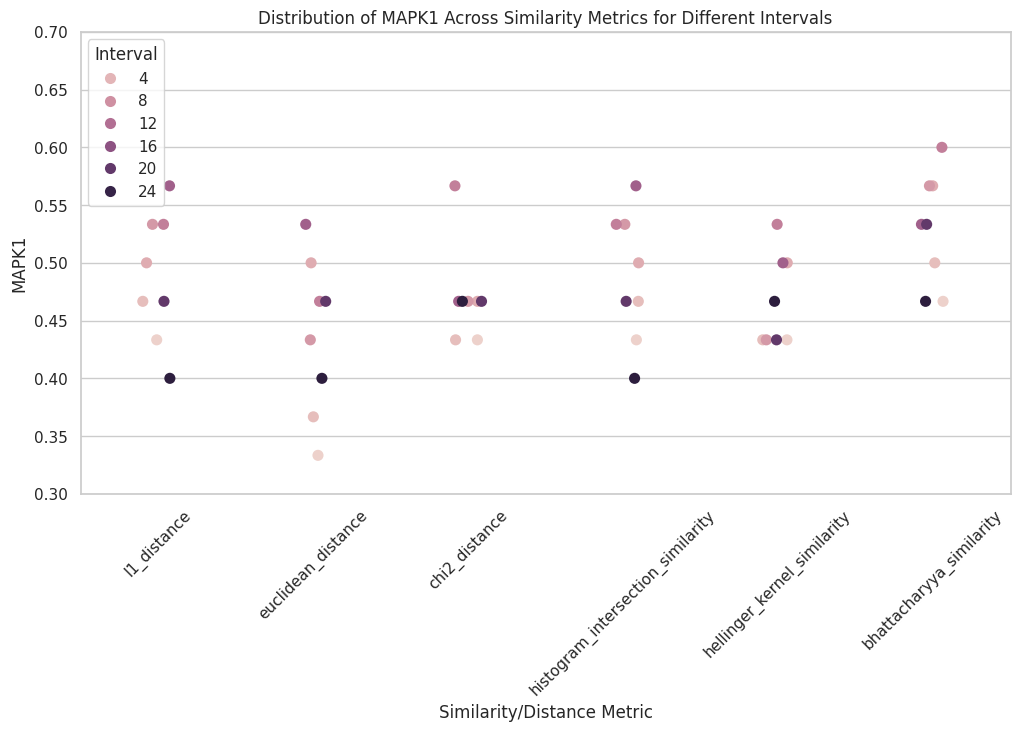

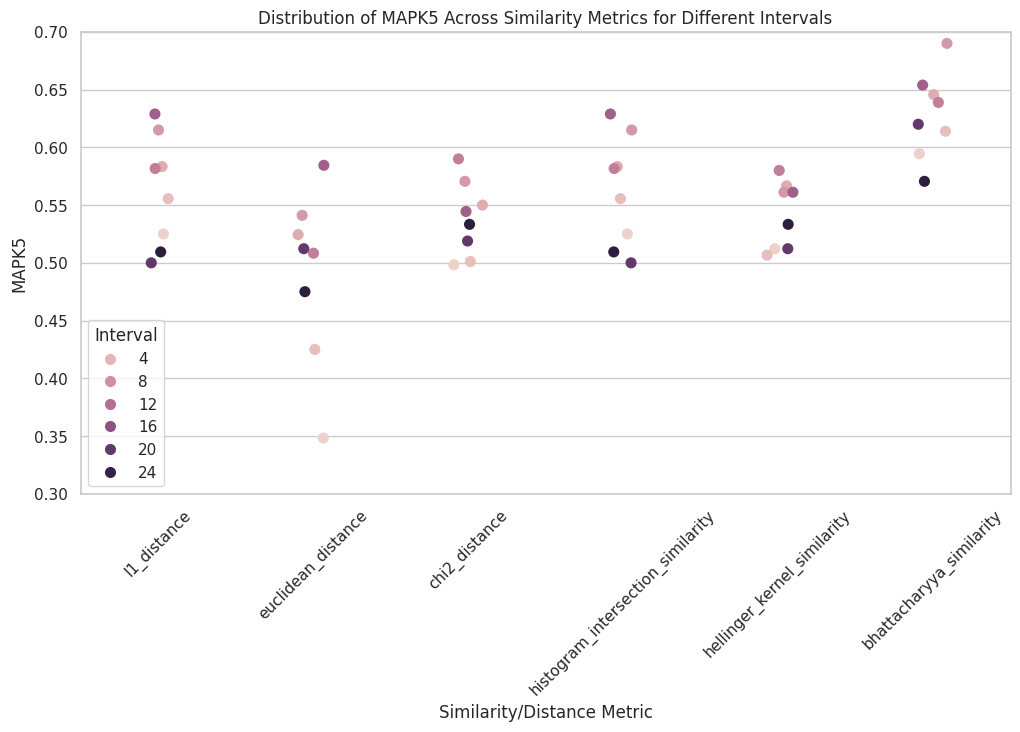

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Flatten the dictionary into a DataFrame
data_list = []

for interval, metrics in result.items():
    for similarity, values in metrics.items():
        data_list.append({
            'Interval': interval,
            'Similarity': similarity,
            'MAPK1': values['mapk1'],
            'MAPK5': values['mapk5']
        })

df = pd.DataFrame(data_list)

# Plot for MAPK1
sns.set(style="whitegrid", palette="muted")
plt.figure(figsize=(12, 6))
sns.stripplot(data=df, x="Similarity", y="MAPK1", hue="Interval", marker="o", size=8)
plt.title('Distribution of MAPK1 Across Similarity Metrics for Different Intervals')
plt.xlabel('Similarity/Distance Metric')
plt.ylabel('MAPK1')
plt.xticks(rotation=45)
plt.legend(title="Interval", loc='best')
plt.ylim((0.3, 0.7))
plt.show()

# Plot for MAPK5
plt.figure(figsize=(12, 6))
sns.stripplot(data=df, x="Similarity", y="MAPK5", hue="Interval", marker="o", size=8)
plt.title('Distribution of MAPK5 Across Similarity Metrics for Different Intervals')
plt.xlabel('Similarity/Distance Metric')
plt.ylabel('MAPK5')
plt.xticks(rotation=45)
plt.legend(title="Interval", loc='best')
plt.ylim((0.3, 0.7))
plt.show()

## Task 4

In [8]:
""" 
# TASK 4: Submit your results for a “blind” competition in QST1

Format: For each test query in QST1, a list of the K=10 best results:
    - Create a python list of lists, with the image ids (integer numbers)
    - Example with 3 queries and K=2
        Query: [[q1], [q2], [q3]]
        Result: [[7,2], [76, 4], [43, 12]]
    Where 7 corresponds to image 00007.jpg, etc.
"""

# Read data
bdd_dataset_i7 = ImageDataset(BBDD_PATH, colorspace=ColorSpace.CieLab, interval=7)
test_dataset_i7 = ImageDataset(TEST_PATH, colorspace=ColorSpace.CieLab, interval=7)

bdd_dataset_i14 = ImageDataset(BBDD_PATH, colorspace=ColorSpace.CieLab, interval=14)
test_dataset_i14 = ImageDataset(TEST_PATH, colorspace=ColorSpace.CieLab, interval=14)

In [16]:

result = []
for image in test_dataset_i7:
    similarities_list = []
    for image2 in bdd_dataset_i7:
        similarities = image.compute_similarity(image2, type=SimilarityType.bhattacharyya)
        similarity = np.mean(similarities)
        similarities_list.append(similarity)
    top_k = np.argsort(similarities_list)[-5:][::-1]

    result.append([bdd_dataset_i7[i].index for i in top_k])

In [17]:
result

[[174, 27, 276, 51, 225],
 [206, 272, 150, 191, 141],
 [155, 140, 144, 88, 96],
 [22, 12, 137, 145, 200],
 [157, 57, 64, 133, 218],
 [23, 225, 119, 271, 241],
 [172, 19, 107, 251, 239],
 [110, 242, 246, 285, 223],
 [215, 39, 239, 82, 163],
 [212, 186, 90, 182, 148],
 [31, 174, 259, 170, 130],
 [184, 202, 22, 92, 93],
 [52, 146, 85, 18, 217],
 [258, 49, 209, 197, 75],
 [100, 20, 95, 42, 200],
 [155, 140, 265, 84, 144],
 [110, 246, 79, 151, 242],
 [241, 242, 170, 32, 271],
 [130, 225, 29, 4, 174],
 [251, 172, 145, 19, 105],
 [120, 236, 95, 229, 222],
 [203, 111, 195, 149, 51],
 [91, 82, 253, 265, 51],
 [212, 182, 141, 97, 186],
 [52, 85, 226, 47, 165],
 [262, 241, 69, 282, 170],
 [227, 140, 69, 144, 233],
 [53, 32, 8, 46, 128],
 [142, 172, 131, 156, 19],
 [32, 218, 64, 241, 57]]

In [13]:
with open(f'{TEST_PATH}/method1.pkl', 'wb') as file:
    # Use pickle.dump to write the list to the file
    pickle.dump(result, file)

In [14]:

result = []
for image in test_dataset_i14:
    similarities_list = []
    for image2 in bdd_dataset_i14:
        similarities = image.compute_distance(image2, type=DistanceType.l1)
        similarity = np.mean(similarities)
        similarities_list.append(similarity)
    top_k = np.argsort(similarities_list)[:5]

    result.append([bdd_dataset_i14[i].index for i in top_k])

In [15]:
with open(f'{TEST_PATH}/method2.pkl', 'wb') as file:
    # Use pickle.dump to write the list to the file
    pickle.dump(result, file)